In [ ]:
import pandas as pd
import numpy as np

# read csv file, columns separated by tab, and save to data frame
df = pd.read_csv('clf_data.csv',sep='\t')
df.columns = ['median_curv', 'min_curv', 'melt_temp','type', 'mfg_process','failure']

# check for null values
df.isnull()

#check fo null values simultaneously appearing in specific columns
# axis 0 and 1 refers to rows and columns respectively
df[df.loc[:,['min_curv', 'melt_temp'] ].isnull().sum(axis=1)==2]
# df[df.loc[:,['min_curv', 'melt_temp'] ].isnull().sum(axis=1)==2].count()

: 

To replace null (NaN) values in a column of a Pandas DataFrame, you can use the fillna() method. This method allows you to replace NaN values with a specified value or method. 
The inplace=True argument modifies the DataFrame in place. If you omit this argument or set it to False, fillna() will return a new DataFrame with the modifications, leaving the original DataFrame unchanged.

In [49]:
df_update = df['melt_temp'].fillna(df['melt_temp'].mean())

# Fill NaN values using forward fill (propagate last valid observation forward)
# df_update = df['melt_temp'].fillna(method='ffill')

# Fill NaN values using backward fill (propagate next valid observation backward)
df_update = df['melt_temp'].fillna(method='backfill')

df_update.isnull().any()

/var/folders/5s/b7sz0shx6qz4p5w457drd7nr0000gp/T/ipykernel_71117/2927992671.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_update = df['melt_temp'].fillna(method='backfill')


True

To remove rows with NaN values from a Pandas DataFrame, you can use the dropna() method. This method offers a flexible way to handle missing values by removing rows (or columns) that contain missing data.

In [50]:
df_cleaned = df.dropna()

If you want to remove rows where all values are NaN, you can specify the how parameter as 'all'.
If you only want to remove rows based on NaN values in specific columns, you can use the subset parameter

In [51]:
# Remove rows where all values are NaN
# df_cleaned_all = df.dropna(how='all') #check how 'all' and 'any' are different
df_cleaned_all = df.dropna(how='any') # removes any row with even one null
df_cleaned_subset = df.dropna(subset=['min_curv', 'melt_temp'])
df_cleaned_subset.count()
print(df_cleaned_all.count())
df_cleaned_all

median_curv    289
min_curv       289
melt_temp      289
type           289
mfg_process    289
failure        289
dtype: int64


,median_curv,min_curv,melt_temp,type,mfg_process,failure
0,1.008164,0.959997,197.0,standard,forged,fatigue
1,1.148136,1.252910,514.0,custom,cast,fretting
3,1.276574,1.064041,1379.0,custom,cast,fatigue
6,1.318799,1.120754,704.0,custom,cast,creep
9,1.500231,1.123470,948.0,standard,cast,fatigue
...,...,...,...,...,...,...
488,1.713505,1.254165,682.0,custom,cast,fatigue
491,1.603568,1.402481,1580.0,custom,cast,fatigue
494,1.155468,0.972179,2205.0,standard,forged,fatigue
495,1.410586,1.183886,1279.0,standard,cast,fretting


We will check Pearson correlations among our numerical variables and drop the highly correlated

In [52]:
df_cleaned_all[['median_curv','min_curv','melt_temp']].corr()

,median_curv,min_curv,melt_temp
median_curv,1.000000,0.819866,-0.076252
min_curv,0.819866,1.000000,-0.077257
melt_temp,-0.076252,-0.077257,1.000000


In [53]:
df.drop('min_curv', axis=1, inplace=True)
# df.drop(columns=['min_curv']) # alternative method
df['melt_temp'].fillna(df['melt_temp'].median(), inplace=True)
df['median_curv'].fillna(df['median_curv'].mean(), inplace=True)
print(df.count())
df.head()

median_curv    500
melt_temp      500
type           500
mfg_process    500
failure        500
dtype: int64


/var/folders/5s/b7sz0shx6qz4p5w457drd7nr0000gp/T/ipykernel_71117/1737883309.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['melt_temp'].fillna(df['melt_temp'].median(), inplace=True)
/var/folders/5s/b7sz0shx6qz4p5w457drd7nr0000gp/T/ipykernel_71117/1737883309.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

,median_curv,melt_temp,type,mfg_process,failure
0,1.008164,197.0,standard,forged,fatigue
1,1.148136,514.0,custom,cast,fretting
2,1.046623,858.0,standard,cast,fatigue
3,1.276574,1379.0,custom,cast,fatigue
4,1.570190,1272.5,custom,cast,fatigue


Sklearn decision tree classifier cannot handle string values. Thus we have to use one hot encoding to convert the strings to multiple columns

In [54]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['type','mfg_process']]).toarray())
enc_df.columns = enc.get_feature_names_out()
data = df.join(enc_df)
data.rename(columns={'0': 'type_custom',
                    '1': 'type_standard',
                    '2': 'mfg_process_cast',
                    '3': 'mfg_process_forged',
                    '4': 'mfg_process_machined'}, inplace=True)
data

,median_curv,melt_temp,type,mfg_process,failure,type_custom,type_standard,mfg_process_cast,mfg_process_forged,mfg_process_machined
0,1.008164,197.0,standard,forged,fatigue,0.0,1.0,0.0,1.0,0.0
1,1.148136,514.0,custom,cast,fretting,1.0,0.0,1.0,0.0,0.0
2,1.046623,858.0,standard,cast,fatigue,0.0,1.0,1.0,0.0,0.0
3,1.276574,1379.0,custom,cast,fatigue,1.0,0.0,1.0,0.0,0.0
4,1.570190,1272.5,custom,cast,fatigue,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
495,1.410586,1279.0,standard,cast,fretting,0.0,1.0,1.0,0.0,0.0
496,1.774378,1536.0,standard,forged,fatigue,0.0,1.0,0.0,1.0,0.0
497,1.443780,1272.5,standard,cast,fatigue,0.0,1.0,1.0,0.0,0.0
498,1.570190,738.0,standard,forged,fatigue,0.0,1.0,0.0,1.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
X = data.drop(columns=['type', 'mfg_process','failure'])
y = data['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

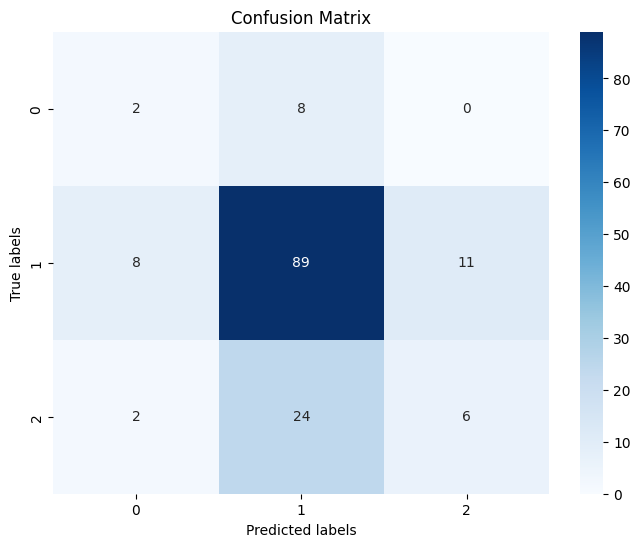

In [ ]:
clf = DecisionTreeClassifier(random_state=32)
clf.fit(X_train, y_train)

# Step 4: Predict the class labels for the testing set
y_pred = clf.predict(X_test)

# Step 5: Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

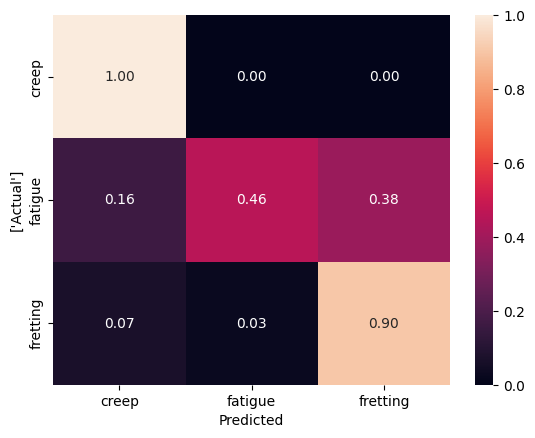

In [ ]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig= plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['creep', 'fatigue', 'fretting'], yticklabels=['creep', 'fatigue', 'fretting'])
plt.ylabel(['Actual'])
plt.xlabel('Predicted')
plt.show()

Our data is imbalanced. We need to adopt a resampling strategy

A manual down samlpling

In [55]:
data['failure'].value_counts()
matching_rows = df[df['failure']=='fatigue']
rows_to_remove = int(len(matching_rows) * (60 / 100))
rows_to_remove_indices = np.random.choice(matching_rows.index, size=rows_to_remove, replace=False)

data_lean = data.drop(rows_to_remove_indices)

In [56]:
data_lean['failure'].value_counts()

failure
fatigue     149
fretting     90
creep        39
Name: count, dtype: int64

In [57]:
# data_lean.drop(columns=['type', 'mfg_process'],inplace=True)
# data_lean.to_csv("clf_data_encoded.csv",sep="\t")

In [62]:
data['failure'].value_counts().max()

371

An alternative approach, upsampling the minority classes; might be better for a dataset that is already small

In [63]:
from sklearn.utils import resample

df_minority = data[data['failure']=='creep']
df_remain = data[data['failure']!='creep']

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,       # Sample with replacement
                                 n_samples=data['failure'].value_counts().max(),    # Match number in majority class
                                 random_state=123)   # Reproducible results

df_upsampled = pd.concat([df_remain, df_minority_upsampled])

data = df_upsampled
# repeat for the other minority class
df_minority = data[data['failure']=='fretting']
df_remain = data[data['failure']!='fretting']

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,       # Sample with replacement
                                 n_samples=data['failure'].value_counts().max(),    # Match number in majority class
                                 random_state=123)   # Reproducible results

df_upsampled = pd.concat([df_remain, df_minority_upsampled])

df_upsampled['failure'].value_counts()
data = df_upsampled

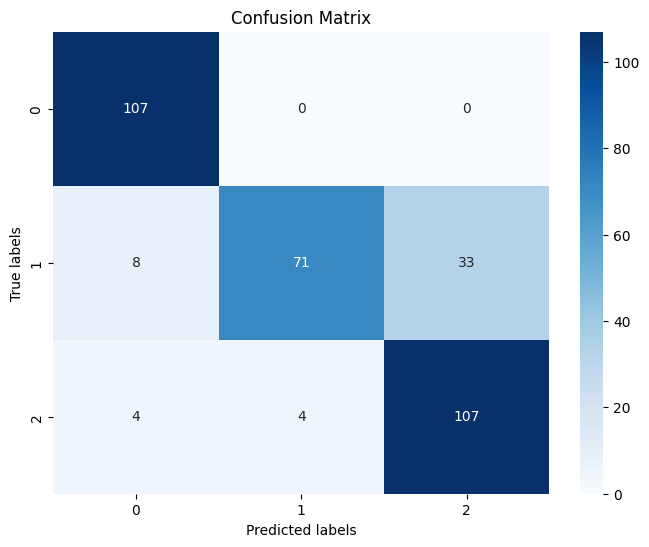

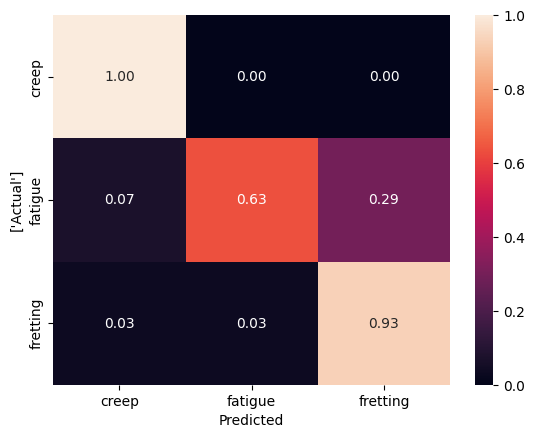

In [64]:
X = data.drop(columns=['type', 'mfg_process','failure'])
y = data['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

clf = DecisionTreeClassifier(random_state=32)
clf.fit(X_train, y_train)

# Step 4: Predict the class labels for the testing set
y_pred = clf.predict(X_test)

# Step 5: Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig= plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', 
            xticklabels=['creep', 'fatigue', 'fretting'], 
            yticklabels=['creep', 'fatigue', 'fretting'])
plt.ylabel(['Actual'])
plt.xlabel('Predicted')
plt.show()

Let us try another classifier, K Nearest Neighbors. We can tune the number of neighrbors K and compare the results to our tree classification

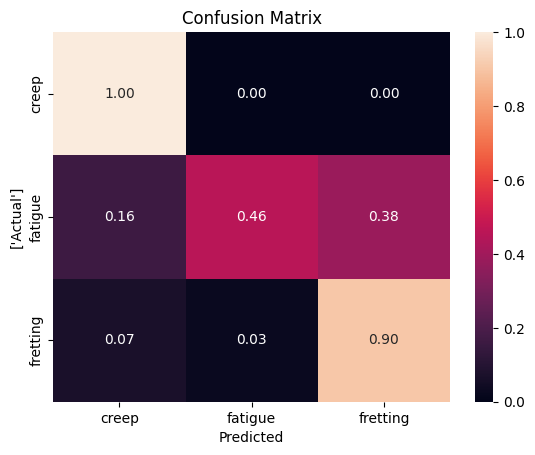

In [65]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig= plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['creep', 'fatigue', 'fretting'], yticklabels=['creep', 'fatigue', 'fretting'])
plt.title('Confusion Matrix')
plt.ylabel(['Actual'])
plt.xlabel('Predicted')
plt.show()

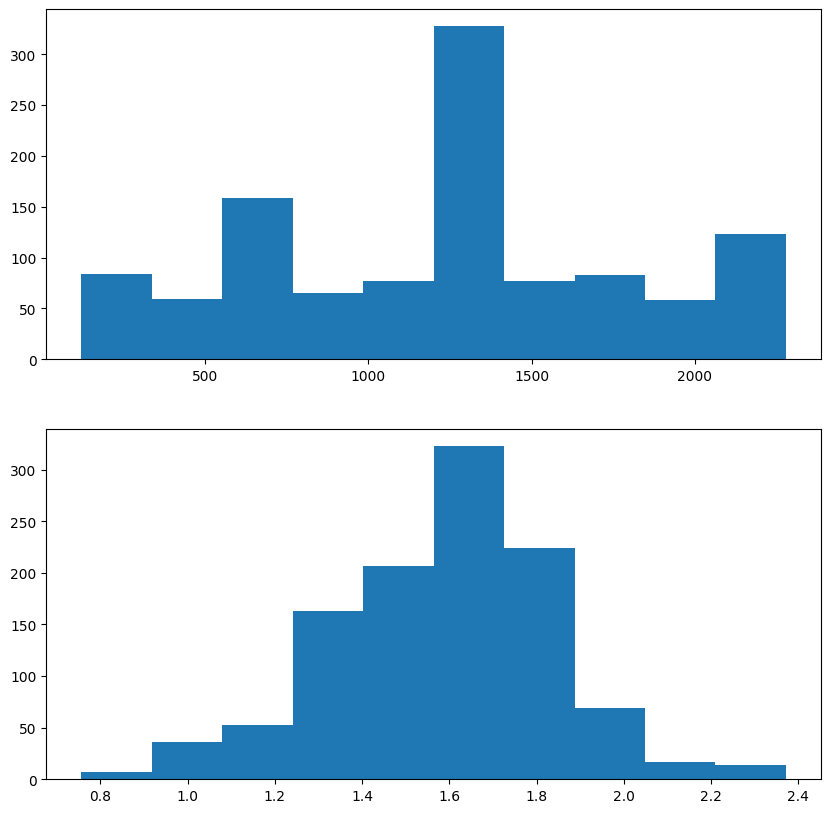

In [66]:
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].hist(data['melt_temp'], bins=10)
axs[1].hist(data['median_curv'], bins=10)
plt.show()